In [10]:
%load_ext autoreload
%autoreload 2

DATA_DIR = '../data/'

# Explore the columns of data and find outliers
import pandas as pd
import os
import os.path as osp
from typing import Optional
import numpy as np
import tqdm 
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import sys
sys.path.append('../')

# Visualization libraries
from source.utils.visualization import *
from source.utils.regions import get_popularity_rank_correlation

SAVE_EXTENSION = '.pdf'
SAVE_DIR = '../figures/'

plot_kwargs = {
    "column" : "half",
    "nrows" : 1,
    "ncols" : 1,
    "usetex" : False
}
setup_plotting_icml2022(
    **plot_kwargs
    )


# Dataset Loading & Preprocess

This section loads the datasets that will be used for exploration into the RAM.
- `charts_df` is responsible for the rankings of the songs of different days and regions
- `audio_df` is responsible for the audio features, which are fetched by using Spotify API in the `data_preprocess.ipynb` notebook.

In [3]:
REFRESH_DATA = True
CHARTS_PATH = osp.join(DATA_DIR,'charts_processed.csv')
AUDIO_PATH = osp.join(DATA_DIR,'audio_features_processed.csv')

In [4]:
if REFRESH_DATA:

    # Load the datasets into dataframes. Read the date column as datetime.date
    charts_df = pd.read_csv(CHARTS_PATH, parse_dates=['date'])

charts_df['date'] = pd.to_datetime(charts_df['date'])

# Display the first few rows of the DataFrame to verify
charts_df.head()

,title,rank,date,artist,url,region,chart,trend,streams
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,Argentina,top200,SAME_POSITION,253019.0
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,https://open.spotify.com/track/7DM4BPaS7uofFul...,Argentina,top200,MOVE_UP,223988.0
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,https://open.spotify.com/track/3AEZUABDXNtecAO...,Argentina,top200,MOVE_DOWN,210943.0
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",https://open.spotify.com/track/6rQSrBHf7HlZjtc...,Argentina,top200,SAME_POSITION,173865.0
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,https://open.spotify.com/track/58IL315gMSTD37D...,Argentina,top200,MOVE_UP,153956.0


In [5]:
if REFRESH_DATA:
    # Load the audio features dataset
    audio_df = pd.read_csv(AUDIO_PATH)

    # Change the column-name of 'id' to 'track_id' to match the charts_df
    audio_df.rename(columns={'id': 'track_id'}, inplace=True)

audio_df.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,track_id
0,0.18700,0.852,195840,0.773,0.000030,8,0.1590,-2.921,0,0.0776,102.034,4,0.907,6mICuAdrwEjh6Y6lroV2Kg
1,0.00431,0.663,259196,0.920,0.000017,11,0.1010,-4.070,0,0.2260,99.935,4,0.533,7DM4BPaS7uofFul3ywMe46
2,0.40000,0.761,222560,0.838,0.000000,4,0.1760,-3.073,0,0.0502,93.974,4,0.710,3AEZUABDXNtecAOSC1qTfo
3,0.55100,0.508,205600,0.687,0.000003,0,0.1260,-4.361,1,0.3260,180.044,4,0.555,6rQSrBHf7HlZjtcMZ4S4bO
4,0.07600,0.899,234320,0.626,0.000000,6,0.0631,-4.228,0,0.2920,88.007,4,0.873,58IL315gMSTD37DOZPJ2hf


# Data Preprocessing
Since `streams` information is only given in "Top 200" charts, this code pieces eliminates the "Viral 50". Although this can be done and saved to a different `.csv` file, to keep the original dataset intact, this is preferred.

In [6]:
# For now only restrict the dataset to top200 charts for stream/ranking analysis.
charts_df = charts_df[charts_df["chart"] == "top200"]
charts_df["track_id"] = charts_df["url"].apply(lambda x: x.split("/")[-1])

# Utility Functions
This section imports some important utility functions.

In [7]:
# Set that each time a library is imported, refresh 
from source.utils.charts import get_charts_by_date, get_charts_by_region
from source.utils.regions import calculate_popularity_metrics,calculate_popularity_metrics_delta
from source.utils.visualization import plot_popularity_rank_correlation, plot_multiple_tracks_time_series
from source.utils.tracks import get_track_artist,get_track_title


In [8]:
# Use case of some utility functions
turkey_df = get_charts_by_region(charts_df, 'Germany', seperete_dict=False)
get_charts_by_date(turkey_df, ('2019-01-01', '2019-12-31'))

,title,rank,date,artist,url,region,chart,trend,streams,track_id
3750462,Benzema,1,2019-01-01,Capital Bra,https://open.spotify.com/track/7KPGeiXWDsGEvFK...,Germany,top200,MOVE_UP,439742.0,7KPGeiXWDsGEvFK62wzU8E
3750463,HaifischNikez Allstars,2,2019-01-01,"LX, Maxwell, Bonez MC, Gzuz, Sa4",https://open.spotify.com/track/0kLA41xkWzzYzMI...,Germany,top200,MOVE_UP,373845.0,0kLA41xkWzzYzMIEGFuDkP
3750464,Sweet but Psycho,3,2019-01-01,Ava Max,https://open.spotify.com/track/25sgk305KZfyuqV...,Germany,top200,MOVE_DOWN,353209.0,25sgk305KZfyuqVBQIahim
3750465,Baller los,4,2019-01-01,MERO,https://open.spotify.com/track/1IPRghUN3LFPNbC...,Germany,top200,MOVE_UP,285326.0,1IPRghUN3LFPNbCTsfBJx9
3750466,Tausend Tattoos,5,2019-01-01,Sido,https://open.spotify.com/track/2PAYSgrVOBz8RJq...,Germany,top200,SAME_POSITION,247009.0,2PAYSgrVOBz8RJqp9B7QLu
...,...,...,...,...,...,...,...,...,...,...
10790168,Take on Me,196,2019-12-31,a-ha,https://open.spotify.com/track/2WfaOiMkCvy7F5f...,Germany,top200,NEW_ENTRY,91082.0,2WfaOiMkCvy7F5fcp2zZ8L
10790169,Post Malone (feat. RANI) - VIZE Remix,197,2019-12-31,Sam Feldt,https://open.spotify.com/track/3mruwwpKfG5NYmn...,Germany,top200,NEW_ENTRY,90931.0,3mruwwpKfG5NYmnEr6O5Dw
10790170,Cordula Grün,198,2019-12-31,Die Draufgänger,https://open.spotify.com/track/0ONG1FsI74VqnjK...,Germany,top200,NEW_ENTRY,90925.0,0ONG1FsI74VqnjK2WHxBL0
10790171,Summer Days (feat. Macklemore & Patrick Stump ...,199,2019-12-31,Martin Garrix,https://open.spotify.com/track/40OMBMYRk5IQL6x...,Germany,top200,NEW_ENTRY,90302.0,40OMBMYRk5IQL6xCzGM0JA


## Popularity Analysis

### Issue with the feature "rank" and "streams"
Using the stream in the analysis is a risky since _same songs, with same audio features, can appear multiple times in a chart list with different rankings_. This would mean that a track $t$ has multiple *streams* and *ranking* values. If we want to find a correlation between an audio feature and the streams/rankings for a given date $[a,a + \Delta t]$, there should be a unique _dependent variable_. One way to solve this problem is using aggragation operations to sum the information of multiple days to get a single value we want to correlate. For example we can assign a unique ranking to every song that appeared in "Top 200" charts of a week. This would mean that we would:

1. Sum all the streams of each tracks
2. Re-organize the ranking charts to give them a unique ranking based on their streams. Notice that lowest (worst) ranking that can be achieved is lesser than 200 unless all the songs that appears in the "Top 200" chart of a week contains only the same tracks.

However this approach also comes with a problem : a track appears in "Top 200" charts in multiple weeks which would mean using information of different time ranges to create a single correlation is wrong as there is a high chance that a track will appear in both weeks with different rankings and streams. Another problem is *amount of streams changes by time* which is expected since "Spotify" gets populer each year, which would result in higher amount of streams (altough with same ranking). With these issues on mind, define _stream proportion_ of a track $t$ as the normalized stream:
$$
\hat s(t,d) = \frac{s(t,d)}{\sum_{i=1}^{200} s(t_i,d)}
$$ where $d$ is the date. Using stream proportion instead of streams and rank would give us a more fair comparison between tracks that appears in different time of year.

### Popularity
Define the k-popularity of a track $t$ as the total number of $Top-k$ apperance of a track between the given range $[a,b]$ :
$$
p(k,t) = \sum_{d=a}^b \mathbb 1[r(t,d) \lt k]
$$
where $\mathbb 1$ is an indicator function and $r(t,d)$ gives us the ranking of a track $t$ on a specific date $d$. To avoid any error, if a track $t$ does not appear on a date $d$, this indicator should always return $0$.

Altough this popularity metric uses the information of how frequent a track appears on a chart, it does not use a metric correlated with streams. Define the average k-stream proportion of a track $t$ as:
$$
s_k(t,d) = \frac{\sum_{d=a}^b \mathbb 1[r(t,d) \lt k]s(t,d)}{\sum_{d=a}^b \mathbb 1[r(t,d) \leq k]}
$$

Final popularity is defined as: $$s_k(t,d) p(k,t)$$ which is simply the sum of stream proportions of a track $t$ for its Top-k entries. We will note this metric as *weighted_popularity*. 


First let us show that sum of stream proportion of a track is *highly correlated with the* overall ranking of a track within the given time period. This is expected since stream is highly correlated with the stream proportion.

In [12]:

# Call the function with the required parameters
popularity_rank_corrs_dict = {}
for region in tqdm.tqdm(charts_df['region'].unique()):
    rank_corrs = get_popularity_rank_correlation(get_charts_by_region(charts_df, region),
                                    k=200,
                                    date_range=('2017-01-01', '2022-01-01')
                                    )
    popularity_rank_corrs_dict[region] = rank_corrs

100%|██████████| 69/69 [09:04<00:00,  7.90s/it]


In [13]:
spearman_corrs = {region: corr[1][0] for region, corr in popularity_rank_corrs_dict.items()}
spearman_corrs_p = {region: corr[1][1] for region, corr in popularity_rank_corrs_dict.items()}

# Plot the correlation values
print(f"Mean Spearman correlation: {np.mean(list(spearman_corrs.values())):.3f} with mean p-value: {np.mean(list(spearman_corrs_p.values()))}")
print(f"Max correlation and Min correliaton : {np.max(list(spearman_corrs.values())):.3f} and {np.min(list(spearman_corrs.values())):.3f}")
print(f"Correlation of ranks and popularity in the Global charts : {popularity_rank_corrs_dict['Global'][1][0]:.3f}, p-value: {popularity_rank_corrs_dict['Global'][1][1]:.3f}")

Mean Spearman correlation: -0.975 with mean p-value: 0.0
Max correlation and Min correliaton : -0.865 and -0.998
Correlation of ranks and popularity in the Global charts : -0.995, p-value: 0.000


The minor difference is due to the fact that stream-proportion is normalized based on other songs in the chart. This suggest that `popularity` with $k=200$ is indeed a great metric to use for other metrics such as streams and rank; and higher the popularity is, lower the ranking (rank 1 is the best) is.

## Popularity Example
In this section, we show one example of pouplarity graph to see our `weighted_popularity` metric is a suitable choice.

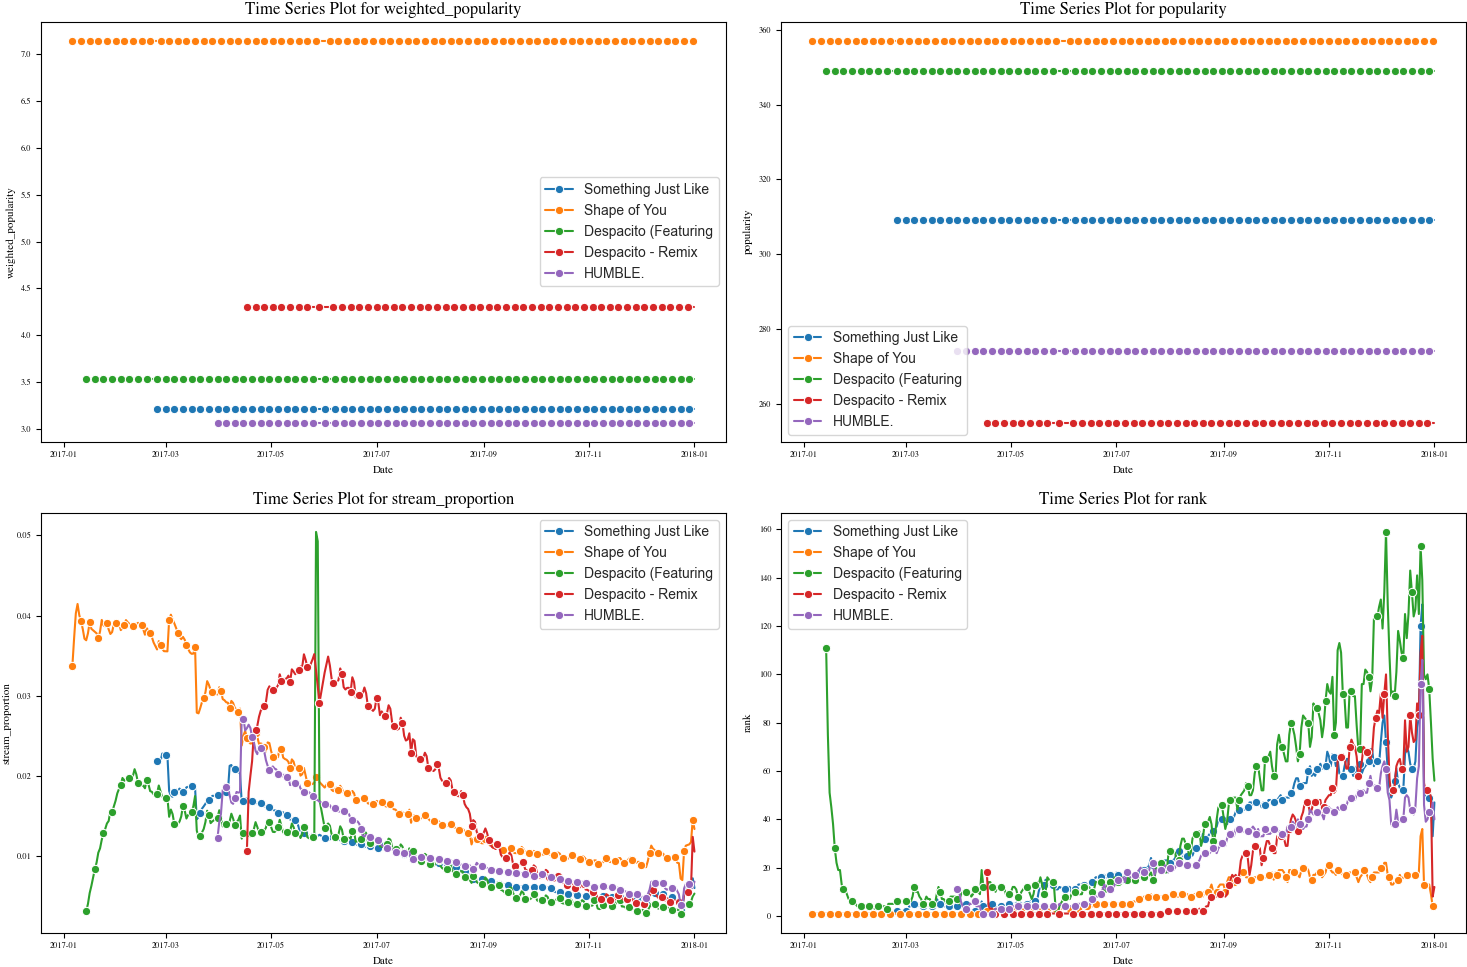

In [14]:
from source.utils.visualization import plot_popular_tracks_time_series
plot_popular_tracks_time_series(charts_df, "Global", ('2017-01-01', '2018-01-01'), 200)